In [144]:
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
from numpy import random
from pathlib import Path
import re
from skimage import io
from typing import (
    Optional, 
    Union, 
    Sequence, 
    Callable, 
    Dict, 
    List
)
#from monai.data.utils import is_supported_format
#from monai. data.image_reader import (
#    _copy_compatible_dict, 
#    _stack_images
#)
from nibabel.nifti1 import Nifti1Image
from PIL import Image
import numpy as np
from tqdm import tqdm
import pickle
import pandas as pd
from os.path import exists
import torch as t
#from mlflow import log_metric, log_param, log_artifacts, set_experiment, start_run, end_run
import warnings
warnings.filterwarnings('ignore')
from skimage.transform import resize
from monai.transforms import Spacing, FillHoles
import matplotlib.pyplot as plt
from monai.metrics import compute_meandice

In [145]:
dice_metric_test = DiceMetric(
    include_background=False,
    reduction="mean"
)

In [146]:
#make list of data dictionaries
train_images_path = Path('../TBI/GT_filtered+raw/') #raw path images
train_images_paths = list(train_images_path.glob('*.tif'))#get images
train_images = sorted([x.as_posix() for x in train_images_paths if 'Result' not in x.as_posix()])#sort
train_labels_path = Path('../TBI/GT_filtered+raw/')#labels path
train_labels = list(train_labels_path.glob('*sub1.tiff'))#get label images
train_labels = sorted([x.as_posix() for x in train_labels])#sort
#combine images and labels into monai dictionary format
data_dicts = [
    {"image":image_name, "label":label_name}
    for image_name, label_name in zip(train_images,train_labels)
]

In [147]:
data_dicts

[{'image': '../TBI/GT_filtered+raw/XYZres008.tif',
  'label': '../TBI/GT_filtered+raw/XYZres008_Simple Segmentation_sub1.tiff'},
 {'image': '../TBI/GT_filtered+raw/XYZres013_0001.tif',
  'label': '../TBI/GT_filtered+raw/XYZres013_0001_Simple Segmentation_sub1.tiff'},
 {'image': '../TBI/GT_filtered+raw/XYZres018_0001.tif',
  'label': '../TBI/GT_filtered+raw/XYZres018_0001_Simple Segmentation_sub1.tiff'},
 {'image': '../TBI/GT_filtered+raw/XYZres025.tif',
  'label': '../TBI/GT_filtered+raw/XYZres025_Simple Segmentation_sub1.tiff'},
 {'image': '../TBI/GT_filtered+raw/XYZres032.tif',
  'label': '../TBI/GT_filtered+raw/XYZres032_Simple Segmentation_sub1.tiff'},
 {'image': '../TBI/GT_filtered+raw/XYZres037.tif',
  'label': '../TBI/GT_filtered+raw/XYZres037_Simple Segmentation_sub1.tiff'},
 {'image': '../TBI/GT_filtered+raw/XYZres042_0001.tif',
  'label': '../TBI/GT_filtered+raw/XYZres042_0001_Simple Segmentation_sub1.tiff'},
 {'image': '../TBI/GT_filtered+raw/XYZres050.tif',
  'label': '../T

In [148]:
mouse_ids_path = Path('../TBI/raw')#each mouse has its own folder with raw data in it
mouse_ids = list(mouse_ids_path.glob('*'))#grab molder names/mouse ids
images = sorted([y.name for y in train_images_paths])#sort
#get mouse id corresponding to each image i have labels for
mouse_ids_with_raw_tiff = []
for i in mouse_ids:
    for j in images:
        if len(list(i.glob(j))) !=0:
            mouse_ids_with_raw_tiff.append(list(i.glob(j)))
#flatten the list and sort
mouse_ids_with_raw_tiff_flat = [item for sublist in mouse_ids_with_raw_tiff for item in sublist]
mouse_ids_with_raw_tiff_flat = sorted(mouse_ids_with_raw_tiff_flat)

In [149]:
#shuffle mouse ids for a 15/4/6 split train/val/test by mouse id
mouse_ids_present = [i.parent.name for i in mouse_ids_with_raw_tiff_flat]
mouse_ids_present = sorted(list(np.unique(mouse_ids_present)))
np.random.seed(643)
np.random.shuffle(mouse_ids_present)
mouse_ids_present
train = mouse_ids_present[:15]
#log_param('train_set',' '.join(train))
val = mouse_ids_present[15:-6]
#log_param('val_set',' '.join(val))
test = mouse_ids_present[-6:]

In [150]:
train_files = []
val_files = []
test_files = []
for i in train:
    for j in mouse_ids_with_raw_tiff_flat:
        if i in j.as_posix():
            for k in data_dicts:
                if j.name in k["image"]:
                    train_files.append(k)
for i in val:
    for j in mouse_ids_with_raw_tiff_flat:
        if i in j.as_posix():
            for k in data_dicts:
                if j.name in k["image"]:
                    val_files.append(k)
for i in test:
    for j in mouse_ids_with_raw_tiff_flat:
        if i in j.as_posix():
            for k in data_dicts:
                if j.name in k["image"]:
                    test_files.append(k)

In [196]:
vessel_dsc=[]
vessel_recall=[]
vessel_precision = []
neuron_dsc=[]
neuron_recall = []
neuron_precision = []
dsc_combined = []
DSC = []
RECALL = []
PRECISION = []
for file in tqdm(test_files):
    if exists(re.sub('.tif','_mean.npy',re.sub(str('../TBI/GT_filtered\+raw'),'matt_preds',file['image']))):
        pred = np.argmax(np.load(re.sub('.tif','_mean.npy',re.sub(str('../TBI/GT_filtered\+raw'),'matt_preds',file['image']))),axis=0)
        pred = np.expand_dims(pred,axis=0)
        pred = FillHoles(connectivity=2)(pred)[0]
        #pred = np.load(re.sub('.tif','_seg.npy',re.sub(str('../TBI/GT_filtered\+raw'),'matt_preds',file['image'])))
    elif exists(re.sub('.tif','_mean.npy',re.sub(str('../TBI/GT_filtered\+raw'),'james_preds',file['image']))):
        pred = np.argmax(np.load(re.sub('.tif','_mean.npy',re.sub(str('../TBI/GT_filtered\+raw'),'james_preds',file['image']))),axis=0)
        pred = np.expand_dims(pred,axis=0)
        pred = FillHoles(connectivity=2)(pred)[0]
        #pred = np.load(re.sub('.tif','_seg.npy',re.sub(str('../TBI/GT_filtered\+raw'),'james_preds',file['image'])))
    else:
        print('error')
    gt = io.imread(file['label'])
    gt = np.swapaxes(gt,0,1)
    gt = np.swapaxes(gt,1,3)
    gt = np.squeeze(Spacing(pixdim=(1.01, 1.01, 0.3787), mode=("nearest"))(gt)[0],axis=0)
    cats = [1,2]
    for i in cats:
        dsc = (2*np.sum((gt==i)*(pred==i)))/(np.sum(gt==i)+np.sum(pred==i))
        recall = np.sum((gt==i)*(pred==i))/np.sum(gt==i)
        precision = np.sum((gt==i)*(pred==i))/np.sum(pred==i)
        if i == 1:
            vessel_dsc.append(dsc)
            vessel_recall.append(recall)
            vessel_precision.append(precision)
        elif i == 2:
            neuron_dsc.append(dsc)
            neuron_recall.append(recall)
            neuron_precision.append(precision)
    dsc = (2*(np.sum((gt==1)*(pred==1))+np.sum((gt==2)*(pred==2))))/(np.sum(gt!=0)+np.sum(pred!=0))
    recall = (np.sum((gt==1)*(pred==1)) + np.sum((gt==2)*(pred==2)))/(np.sum(gt==1) + np.sum(gt==2))
    precision = (np.sum((gt==1)*(pred==1)) + np.sum((gt==2)*(pred==2)))/(np.sum(pred==1) + np.sum(pred==2))
    DSC.append(dsc)
    RECALL.append(recall)
    PRECISION.append(precision)

100%|██████████| 9/9 [02:52<00:00, 19.12s/it]


In [197]:
print(np.mean(DSC))
print(np.std(DSC))
print(np.mean(RECALL))
print(np.std(RECALL))
print(np.mean(PRECISION))
print(np.std(PRECISION))

0.7548995236457784
0.0664273852734582
0.7886911532887708
0.1489180539207966
0.7481016317268128
0.05418446184044403


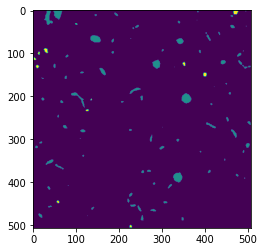

In [198]:
plt.imshow(pred[:,:,110])

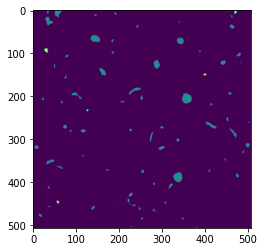

In [199]:
plt.imshow(gt[:,:,110])

In [200]:
np.unique(pred)

array([0, 1, 2])

In [201]:
file

{'image': '../TBI/GT_filtered+raw/XYZres204_0001.tif',
 'label': '../TBI/GT_filtered+raw/XYZres204_0001_Simple Segmentation_sub1.tiff'}

In [202]:

np.sum((gt==1)*(pred==1))/np.sum(gt==1)

0.9289224363470381

In [203]:
vessel_dsc

[0.8463955276553707,
 0.6898777635836488,
 0.5793125937024913,
 0.7872087806551192,
 0.8223787411958078,
 0.8370479980637788,
 0.7776077225521536,
 0.7731097740299114,
 0.804823815236591]

In [204]:
np.mean(2*(np.array(vessel_precision)*np.array(vessel_recall))/(np.array(vessel_precision)+np.array(vessel_recall)))

0.7686403018527637

In [205]:
#Spacing(pixdim=(1.01, 1.01, 0.3787), mode=("nearest"))(gt)

In [206]:
print(np.mean(vessel_dsc))
print(np.std(vessel_dsc))

0.7686403018527637
0.0798722954839931


In [207]:
print(np.mean(vessel_recall))
print(np.std(vessel_recall))

0.7809738704075831
0.15850722600948622


In [208]:
print(np.mean(vessel_precision))
print(np.std(vessel_precision))

0.7851538558497643
0.06252201581350378


In [209]:
print(np.mean(neuron_dsc))
print(np.std(neuron_dsc))

0.6857931726365452
0.05811248280293234


In [210]:
print(np.mean(neuron_recall))
print(np.std(neuron_recall))

0.8654578578063599
0.05300533934616964


In [211]:
print(np.mean(neuron_precision))
print(np.std(neuron_precision))

0.5789620541915783
0.10170465667860913


In [212]:
print(np.mean((vessel_dsc+neuron_dsc)))
print(np.std((vessel_dsc+neuron_dsc)))

0.7272167372446544
0.08120488794736377


In [213]:
print(np.mean((np.array(vessel_dsc)+np.array(neuron_dsc))/2))
print(np.std((np.array(vessel_dsc)+np.array(neuron_dsc))/2))

0.7272167372446544
0.041359436432235816
